In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet
import joblib
import os
import re

C:\Users\dell\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\dell\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
data_2023 = pd.read_excel('VENTE3 2023.xlsx')
data_2022 = pd.read_excel('VENTE3 2022.xlsx',sheet_name='EXTRACT GLOB')
data_2021 = pd.read_excel('Vente3 2021.xlsx')
data_2020 = pd.read_excel('VENTE3 2020 MAJ2 (1).xlsx')
data_2019 = pd.read_excel('VENTE3 2019.xlsx')

In [3]:
d23=data_2023
d22=data_2022
d21=data_2021
d20=data_2020
d19=data_2019

In [4]:
colonnes_a_conserver = ['INVDAT_0', 'Type Fac', 'Article', 'Designation', 'Cat', 'QTEFACT', 'MTHT' , 'FAM CENT','code clt']

d21= d21.rename(columns={'Qtefact US':'QTEFACT'})
d20= d20.rename(columns={'Qtefact US':'QTEFACT'})
d19= d19.rename(columns={'Qtefact US':'QTEFACT'})

d23=d23[colonnes_a_conserver]
d22=d22[colonnes_a_conserver]
d21=d21[colonnes_a_conserver]
d20=d20[colonnes_a_conserver]
d19=d19[colonnes_a_conserver]

In [5]:
df= pd.concat([d19, d20, d21, d22, d23], ignore_index=True)

In [6]:
df['INVDAT_0'] = pd.to_datetime(df['INVDAT_0'])
df = df.sort_values(by='INVDAT_0')

In [7]:
df.columns

Index(['INVDAT_0', 'Type Fac', 'Article', 'Designation', 'Cat', 'QTEFACT',
       'MTHT', 'FAM CENT', 'code clt'],
      dtype='object')

In [8]:
df.describe

<bound method NDFrame.describe of          INVDAT_0 Type Fac     Article                     Designation  Cat  \
98     2019-01-01      FAH  FPSD180401    SET A DINER DRAGON 18 PIECES  NEG   
100    2019-01-01      FAH  FLPT360101            PLAT Ø36CM PRINTEMPS  NEG   
101    2019-01-01      FAH  FUDI000136      GANT A FOUR COTON BARBECUE  NEG   
102    2019-01-01      FAH  FPPT400301   SERIE DE 6 ASSIETTES PERLE 7'  NEG   
103    2019-01-01      FAH  FVSD520003  SALADIER ISIS 30CM VERRE TRANS  NEG   
...           ...      ...         ...                             ...  ...   
644222 2023-12-29      FAC      BP0101               BOITE A PAIN INOX  NEG   
644223 2023-12-29      FAC       T4409             KIT 2 THERMOS 1L+1L  NEG   
644224 2023-12-29      FAC    2046/H6Y    S.6 FOURCHETTES TABLE MIRROR   PF   
644226 2023-12-29      FAC      V1000Y                 VERRE DOSEUR 1L  NEG   
644340 2023-12-29      FAC      PR7014  PLATEAU INOXØ395 A ANSES&NAPPE   PF   

        QTEFACT  

In [9]:
null_values = df.isnull().sum()
print(null_values)

INVDAT_0         0
Type Fac         0
Article          0
Designation      2
Cat              0
QTEFACT          0
MTHT             0
FAM CENT       726
code clt         0
dtype: int64


In [10]:
def supprimer_lignes_par_colonne(dataframe, colone, types_a_supprimer):
    nombre_lignes_avant = len(dataframe)
    dataframe_filtre = dataframe[~dataframe[colone].isin(types_a_supprimer)]
    nombre_lignes_apres = len(dataframe_filtre)
    nombre_lignes_supprimees = nombre_lignes_avant - nombre_lignes_apres
    print(f"Nombre de lignes supprimées : {nombre_lignes_supprimees}")
    return dataframe_filtre

In [11]:
types_a_supprimer_FAC = ['FAH', 'AVH', 'FPS', 'APS']
df=supprimer_lignes_par_colonne(df,'Type Fac',types_a_supprimer_FAC)

Nombre de lignes supprimées : 71199


In [12]:
types_a_supprimer_Article = ['C', 'B', 'DIVERS/SERVICES', 'FRETS','DECHET','ACF','CADEAU2']
df=supprimer_lignes_par_colonne(df,'Article',types_a_supprimer_Article)

Nombre de lignes supprimées : 21988


In [13]:
types_a_supprimer_cat = ['EMB','GEN','MP','PF2','PF3','SF','SFN']
df=supprimer_lignes_par_colonne(df,'Cat',types_a_supprimer_cat)

Nombre de lignes supprimées : 583


In [14]:
types_a_supprimer_fam = ['FAC','FAT','FIN','FNV','FPE','FTH','FUC']
df=supprimer_lignes_par_colonne(df,'FAM CENT',types_a_supprimer_fam)

Nombre de lignes supprimées : 304


In [15]:
def afficher_valeurs_distinctes(dataframe, colonne):
    valeurs_distinctes = dataframe[colonne].unique()
    print(f"Valeurs distinctes dans la colonne '{colonne}':")
    for valeur in valeurs_distinctes:
        print(valeur)

#x=afficher_valeurs_distinctes(df, 'Article')

In [16]:
def afficher_valeurs_distinctes_et_designations(dataframe):
    # Extraire les lignes distinctes basées sur les colonnes 'Article' et 'Designation'
    df_distinct = dataframe.drop_duplicates(subset=['Article', 'Designation'])
    
    print(f"Valeurs distinctes dans la colonne 'Article' et leurs désignations associées:")
    for index, row in df_distinct.iterrows():
        print(f"Article: {row['Article']}, Désignation: {row['Designation']}")
#afficher_valeurs_distinctes_et_designations(df)

In [17]:
def afficher_designations_par_article(dataframe):
    colonne_article='Article'
    colonne_designation='Designation'
    
    
    articles_input = input("Entrez les articles, séparés par des espaces : ")
    
    # Séparer les articles en utilisant les espaces
    articles_saisis = articles_input.split()
    
    # Afficher les désignations des articles saisis
    for article in articles_saisis:
        designation = dataframe[dataframe[colonne_article] == article][colonne_designation].values
        if len(designation) > 0:
            print(f"Désignation de l'article '{article}': {designation[0]}")
        else:
            print(f"L'article '{article}' n'a pas été trouvé dans le DataFrame.")

In [9]:
def afficher_nombre_ventes_par_annee(dataframe):
    colonne_article ='Article'
    colonne_date ='INVDAT_0'
    colonne_qte ='QTEFACT'
    article = input("Entrez l'article : ")
    
    df_article = dataframe[dataframe[colonne_article] == article].copy()
    
    if df_article.empty:
        print(f"L'article '{article}' n'a pas été trouvé dans le DataFrame.")
        return
    
    df_article.loc[:, 'Année'] = pd.to_datetime(df_article[colonne_date]).dt.year
    
    ventes_par_annee = df_article.groupby('Année')[colonne_qte].sum().reset_index()
    
    print(f"Nombre de ventes pour l'article '{article}' par année :")
    for _, row in ventes_par_annee.iterrows():
        print(f"Année {row['Année']}: {row[colonne_qte]} ventes")

In [19]:
def afficher_nombre_ventes_par_annee(dataframe):
    colonne_article ='Article'
    colonne_date ='INVDAT_0'
    colonne_qte ='QTEFACT'
    article = input("Entrez l'article : ")
    
    df_article = dataframe[dataframe[colonne_article] == article].copy()
    
    if df_article.empty:
        print(f"L'article '{article}' n'a pas été trouvé dans le DataFrame.")
        return
    
    df_article.loc[:, 'Année'] = pd.to_datetime(df_article[colonne_date]).dt.year
    
    ventes_par_annee = df_article.groupby('Année')[colonne_qte].sum().reset_index()
    
    print(f"Nombre de ventes pour l'article '{article}' par année :")
    for _, row in ventes_par_annee.iterrows():
        print(f"Année {row['Année']}: {row[colonne_qte]} ventes")

In [ ]:
# Fonction pour nettoyer les noms de fichiers
def sanitize_filename(filename):
    return re.sub(r'[\\/*?:"<>|]', '_', filename)

# Assurez-vous que le DataFrame `df` est déjà défini
# Liste des articles uniques
articles = df['Article'].unique()

# Créez un répertoire pour sauvegarder les modèles, si nécessaire
save_directory = 'Model'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Générer une plage de dates de 2019 à 2023 (au début de chaque mois)
date_range = pd.date_range(start='2019-01-01', end='2023-12-01', freq='MS')
df_complete = pd.DataFrame({'Période': date_range})

for art in articles:
    # Préparation des données pour chaque article
    df_article = df[df['Article'] == art]

    # Suppression des colonnes non nécessaires
    df_article = df_article.drop(columns=['Designation', 'Cat', 'MTHT', 'FAM CENT', 'code clt', 'Article', 'Type Fac'])

    # Conversion des dates
    df_article['INVDAT_0'] = pd.to_datetime(df_article['INVDAT_0'], errors='coerce')
    df_article['Période'] = df_article['INVDAT_0'].dt.to_period('M').dt.to_timestamp()

    # Groupement par 'Période' et agrégation des quantités
    colonnes_numeriques = df_article.select_dtypes(include=['number']).columns
    df_article_m = df_article.groupby('Période')[colonnes_numeriques].sum().reset_index()

    # Fusion avec la plage complète de dates pour combler les mois manquants avec des zéros
    df_article_m = df_complete.merge(df_article_m, on='Période', how='left').fillna(0)

    # Renommage des colonnes pour Prophet
    df_prophet = df_article_m.rename(columns={'Période': 'ds', 'QTEFACT': 'y'})

    # Ajuster le modèle Prophet
    model = Prophet()
    model.fit(df_prophet)

    # Sauvegarder le modèle
    filename = os.path.join(save_directory, f'{sanitize_filename(art)}_prophet_model.pkl')
    joblib.dump(model, filename)
    print(f"Modèle pour l'article {art} sauvegardé sous {filename}.")


In [10]:
afficher_nombre_ventes_par_annee(df)

Entrez l'article : 6264/GY1
Nombre de ventes pour l'article '6264/GY1' par année :
Année 2019.0: 48895.0 ventes
Année 2020.0: 46349.0 ventes
Année 2021.0: 47491.0 ventes
Année 2022.0: 46243.0 ventes
Année 2023.0: 59904.0 ventes


In [ ]:
# Fonction pour nettoyer les noms de fichiers
def sanitize_filename(filename):
    return re.sub(r'[\\/*?:"<>|]', '_', filename)

# Assurez-vous que le DataFrame `df` est déjà défini
# Liste des articles uniques
articles = df['Article'].unique()

# Créez un répertoire pour sauvegarder les modèles, si nécessaire
save_directory = 'Model'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Générer une plage de dates de 2019 à 2023 (au début de chaque mois)
date_range = pd.date_range(start='2019-01-01', end='2023-12-01', freq='MS')
df_complete = pd.DataFrame({'Période': date_range})

# Préparation des données pour chaque article
df_article = df[df['Article'] == art]

# Suppression des colonnes non nécessaires
df_article = df_article.drop(columns=['Designation', 'Cat', 'MTHT', 'FAM CENT', 'code clt', 'Article', 'Type Fac'])

    # Conversion des dates
df_article['INVDAT_0'] = pd.to_datetime(df_article['INVDAT_0'], errors='coerce')
df_article['Période'] = df_article['INVDAT_0'].dt.to_period('M').dt.to_timestamp()

    # Groupement par 'Période' et agrégation des quantités
colonnes_numeriques = df_article.select_dtypes(include=['number']).columns
df_article_m = df_article.groupby('Période')[colonnes_numeriques].sum().reset_index()

    # Fusion avec la plage complète de dates pour combler les mois manquants avec des zéros
df_article_m = df_complete.merge(df_article_m, on='Période', how='left').fillna(0)

    # Renommage des colonnes pour Prophet
df_prophet = df_article_m.rename(columns={'Période': 'ds', 'QTEFACT': 'y'})

    # Ajuster le modèle Prophet
model = Prophet()
model.fit(df_prophet)



Donner l'Article : 1010/B4


21:52:02 - cmdstanpy - INFO - Chain [1] start processing
21:52:03 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\dell\anaconda3\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


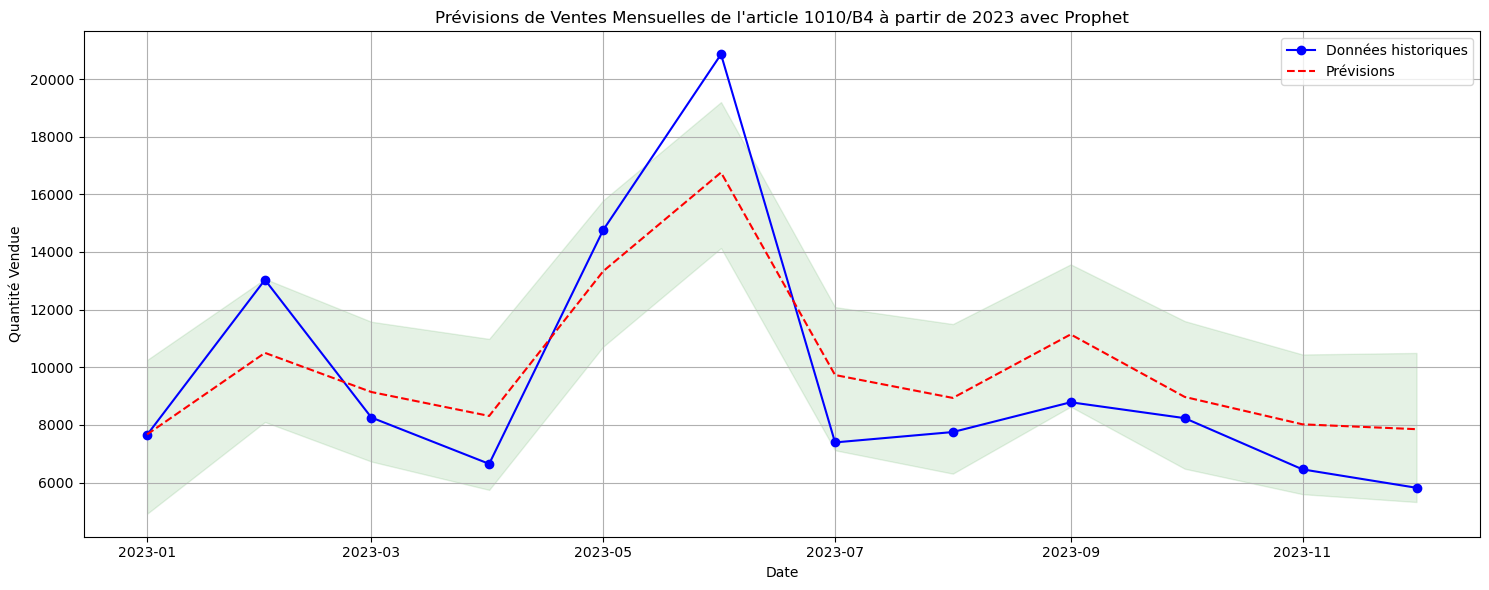

Le modèle a prédit 77 % des valeurs réelles.


In [41]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

art = input('Donner l\'Article : ')

# Générer une plage de dates de 2019 à 2023 (au début de chaque mois)
date_range = pd.date_range(start='2019-01-01', end='2023-12-01', freq='MS')
df_complete = pd.DataFrame({'Période': date_range})

# Préparation des données pour chaque article
df_article = df[df['Article'] == art]

# Suppression des colonnes non nécessaires
df_article = df_article.drop(columns=['Designation', 'Cat', 'MTHT', 'FAM CENT', 'code clt', 'Article', 'Type Fac'])

# Conversion des dates
df_article['INVDAT_0'] = pd.to_datetime(df_article['INVDAT_0'], errors='coerce')
df_article['Période'] = df_article['INVDAT_0'].dt.to_period('M').dt.to_timestamp()

# Groupement par 'Période' et agrégation des quantités
colonnes_numeriques = df_article.select_dtypes(include=['number']).columns
df_article_m = df_article.groupby('Période')[colonnes_numeriques].sum().reset_index()

# Fusion avec la plage complète de dates pour combler les mois manquants avec des zéros
df_article_m = df_complete.merge(df_article_m, on='Période', how='left').fillna(0)

# Renommage des colonnes pour Prophet
df_prophet = df_article_m.rename(columns={'Période': 'ds', 'QTEFACT': 'y'})

# Ajuster le modèle Prophet
model = Prophet()
model.fit(df_prophet)

# Faire des prévisions pour les 12 mois suivants
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

# Mettre les valeurs négatives de yhat à zéro
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(0, x))

# Filtrer les prévisions et les données historiques pour 2023 et au-delà
start_date = pd.Timestamp('2023-01-01')
df_prophet_filtered = df_prophet[df_prophet['ds'] >= start_date]
forecast_filtered = forecast[forecast['ds'] >= start_date]

# S'assurer que les deux séries ont la même longueur en alignant les dates
merged = pd.merge(df_prophet_filtered[['ds', 'y']], forecast_filtered[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

actual_values = merged['y'].values
forecasted_values = merged['yhat'].values

# Visualisation simplifiée des prévisions
plt.figure(figsize=(15, 6))
plt.plot(merged['ds'], actual_values, label='Données historiques', color='blue', marker='o')
plt.plot(merged['ds'], forecasted_values, label='Prévisions', color='red', linestyle='--')
plt.fill_between(merged['ds'], merged['yhat_lower'], merged['yhat_upper'], color='green', alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Quantité Vendue')
plt.title(f"Prévisions de Ventes Mensuelles de l'article {art} à partir de 2023 avec Prophet")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calcul des erreurs de prévision pour les 12 derniers mois
mse = mean_squared_error(actual_values, forecasted_values)
mae = mean_absolute_error(actual_values, forecasted_values)
r2 = r2_score(actual_values, forecasted_values)


print("Le modèle a prédit", int(r2*100), "% des valeurs réelles.")


In [29]:
df

,INVDAT_0,Type Fac,Article,Designation,Cat,QTEFACT,MTHT,FAM CENT,code clt
24071,2019-01-02,FVE,P21/18/G,CRÊPIÈRE A-ADH EMERAUDE 21CM,PF,1800.0,58794.80400,AC,1C0801247
24077,2019-01-02,FVE,B7B4,"COUTEAU BOUCHER 7"""" MABROUKA",NEG,864.0,5113.96416,CP,1C0801247
24088,2019-01-02,FVE,710,S. 12 COUTEAUX CUISINE HADDA1,PF,1000.0,19400.97000,CM,1C0801247
24087,2019-01-02,FVE,1010,S. 12 COUTEAUX CUISINE HADDA2,PF,920.0,21882.54040,CM,1C0801247
24066,2019-01-02,FVE,T4405,"THERMOS INOX 1,5L",NEG,180.0,13771.40040,AM,1C0801247
...,...,...,...,...,...,...,...,...,...
644222,2023-12-29,FAC,BP0101,BOITE A PAIN INOX,NEG,4.0,456.00000,UC,1A0301082
644223,2023-12-29,FAC,T4409,KIT 2 THERMOS 1L+1L,NEG,24.0,1624.50000,AM,1A0301082
644224,2023-12-29,FAC,2046/H6Y,S.6 FOURCHETTES TABLE MIRROR,PF,250.0,2250.00000,CT,1B0101359
644226,2023-12-29,FAC,V1000Y,VERRE DOSEUR 1L,NEG,6.0,87.30000,UC,1B0101359


In [20]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import os
import joblib

# Assurez-vous que le DataFrame `df` est déjà défini

# Préparation des données pour l'article '1010'
art = '2046/H6Y'
df_article = df[df['Article'] == art]

# Suppression des colonnes non nécessaires
df_article = df_article.drop(columns=['Designation', 'Cat', 'MTHT', 'FAM CENT', 'code clt', 'Article', 'Type Fac'])

# Conversion des dates
df_article['INVDAT_0'] = pd.to_datetime(df_article['INVDAT_0'], errors='coerce')
df_article['Période'] = df_article['INVDAT_0'].dt.to_period('M').dt.to_timestamp()

# Groupement par 'Période' et agrégation des quantités
df_article_m = df_article.groupby('Période')['QTEFACT'].sum().reset_index()

# Générer une plage de dates complète de 2019 à 2023 pour combler les mois manquants
date_range = pd.date_range(start='2019-01-01', end='2023-12-01', freq='MS')
df_complete = pd.DataFrame({'Période': date_range})
df_article_m = df_complete.merge(df_article_m, on='Période', how='left').fillna(0)

# Séparation en train/test
train_size = int(len(df_article_m) * 0.8)
train, test = df_article_m.iloc[:train_size], df_article_m.iloc[train_size:]

# Modèle Prophet
df_prophet = train.rename(columns={'Période': 'ds', 'QTEFACT': 'y'})
model_prophet = Prophet()
model_prophet.fit(df_prophet)

# Prévisions Prophet
future = test[['Période']].rename(columns={'Période': 'ds'})
forecast_prophet = model_prophet.predict(future)
y_pred_prophet = forecast_prophet['yhat'].values
rmse_prophet = sqrt(mean_squared_error(test['QTEFACT'], y_pred_prophet))

# Modèle ARIMA
model_arima = ARIMA(train['QTEFACT'], order=(5, 1, 0))  # Ordre à ajuster selon la série
model_arima_fit = model_arima.fit()
y_pred_arima = model_arima_fit.forecast(steps=len(test))
rmse_arima = sqrt(mean_squared_error(test['QTEFACT'], y_pred_arima))

# Modèle LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train['QTEFACT'].values.reshape(-1, 1))

# Préparer les données pour LSTM
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 3
X_train, Y_train = create_dataset(train_scaled, look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Définir le modèle LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# Entraînement
model_lstm.fit(X_train, Y_train, epochs=20, batch_size=1, verbose=2)

# Faire des prévisions avec LSTM
test_scaled = scaler.transform(test['QTEFACT'].values.reshape(-1, 1))
X_test, _ = create_dataset(test_scaled, look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm).flatten()  # Aplatir les prédictions
rmse_lstm = sqrt(mean_squared_error(test['QTEFACT'][look_back + 1:], y_pred_lstm))

# Calculer l'accuracy
def calculate_accuracy(y_true, y_pred):
    """
    Calcule l'accuracy pour la régression en termes d'écart relatif
    entre les valeurs réelles et prédites.
    y_true : valeurs réelles
    y_pred : valeurs prédites
    """
    # Assurez-vous que y_true et y_pred sont de même dimension
    if len(y_true) != len(y_pred):
        raise ValueError("Les dimensions des valeurs réelles et prédites ne correspondent pas.")

    # Calculer l'erreur relative
    relative_error = np.abs((y_true - y_pred) / y_true)
    
    # Calculer la précision en inversant l'erreur relative
    accuracy = (1 - relative_error) * 100
    
    # Retirer les valeurs infinies (ex. division par 0)
    accuracy = np.where(np.isfinite(accuracy), accuracy, 0)
    
    # Retourner la moyenne de l'accuracy
    return np.mean(accuracy)

# Calculer l'accuracy pour chaque modèle
accuracy_prophet = calculate_accuracy(test['QTEFACT'], y_pred_prophet)
accuracy_arima = calculate_accuracy(test['QTEFACT'], y_pred_arima)
accuracy_lstm = calculate_accuracy(test['QTEFACT'][look_back + 1:], y_pred_lstm)

# Afficher les résultats
print(f"RMSE Prophet: {rmse_prophet}")
print(f"RMSE ARIMA: {rmse_arima}")
print(f"RMSE LSTM: {rmse_lstm}")

print(f"Accuracy des prévisions Prophet: {accuracy_prophet:.2f}%")
print(f"Accuracy des prévisions ARIMA: {accuracy_arima:.2f}%")
print(f"Accuracy des prévisions LSTM: {accuracy_lstm:.2f}%")

# Sauvegarder les modèles
save_directory = 'Model'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

# Dictionnaire pour stocker les RMSE des modèles pour chaque article
rmse_results = {
    'Prophet': rmse_prophet,
    'ARIMA': rmse_arima,
    'LSTM': rmse_lstm
}

# Sélection du modèle avec le plus faible RMSE
best_model_name = min(rmse_results, key=rmse_results.get)
best_rmse = rmse_results[best_model_name]

print(f"Le meilleur modèle pour l'article {art} est {best_model_name} avec un RMSE de {best_rmse}.")


17:18:42 - cmdstanpy - INFO - Chain [1] start processing
17:18:42 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/20
44/44 - 4s - loss: 0.0544 - 4s/epoch - 92ms/step
Epoch 2/20
44/44 - 0s - loss: 0.0407 - 184ms/epoch - 4ms/step
Epoch 3/20
44/44 - 0s - loss: 0.0470 - 171ms/epoch - 4ms/step
Epoch 4/20
44/44 - 0s - loss: 0.0394 - 172ms/epoch - 4ms/step
Epoch 5/20
44/44 - 0s - loss: 0.0399 - 177ms/epoch - 4ms/step
Epoch 6/20
44/44 - 0s - loss: 0.0402 - 172ms/epoch - 4ms/step
Epoch 7/20
44/44 - 0s - loss: 0.0408 - 178ms/epoch - 4ms/step
Epoch 8/20
44/44 - 0s - loss: 0.0396 - 176ms/epoch - 4ms/step
Epoch 9/20
44/44 - 0s - loss: 0.0391 - 175ms/epoch - 4ms/step
Epoch 10/20
44/44 - 0s - loss: 0.0399 - 173ms/epoch - 4ms/step
Epoch 11/20
44/44 - 0s - loss: 0.0402 - 176ms/epoch - 4ms/step
Epoch 12/20
44/44 - 0s - loss: 0.0399 - 171ms/epoch - 4ms/step
Epoch 13/20
44/44 - 0s - loss: 0.0399 - 178ms/epoch - 4ms/step
Epoch 14/20
44/44 - 0s - loss: 0.0397 - 175ms/epoch - 4ms/step
Epoch 15/20
44/44 - 0s - loss: 0.0389 - 175ms/epoch - 4ms/step
Epoch 16/20
44/44 - 0s - loss: 0.0392 - 178ms/epoch - 4ms/step
Epo